In [1]:
import tensorflow as tf

# Check available devices
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Devices:", tf.config.list_physical_devices())


Num GPUs Available:  1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:

# TensorFlow is using the GPU
print("TensorFlow is using:", "GPU" if tf.test.is_gpu_available() else "CPU")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
TensorFlow is using: GPU


In [3]:
# Standard libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# For displaying images in the notebook
%matplotlib inline


In [4]:
# Define constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Define dataset directory
dataset_directory = 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'  # Update with the correct path if necessary

# Define classes
classes = ['Cyst', 'Normal', 'Stone', 'Tumor']


In [5]:
import shutil
from sklearn.model_selection import train_test_split

# Create directories for train, validation, and test sets
base_dir = 'kidney_split_dataset'  # Base directory for split dataset

if not os.path.exists(base_dir):
    os.makedirs(base_dir)
    os.makedirs(os.path.join(base_dir, 'train'))
    os.makedirs(os.path.join(base_dir, 'validation'))
    os.makedirs(os.path.join(base_dir, 'test'))

    for subset in ['train', 'validation', 'test']:
        for class_name in classes:
            os.makedirs(os.path.join(base_dir, subset, class_name))

    # Split data and copy images
    for class_name in classes:
        class_dir = os.path.join(dataset_directory, class_name)
        images = os.listdir(class_dir)
        train_val_images, test_images = train_test_split(images, test_size=0.1, random_state=42)
        train_images, val_images = train_test_split(train_val_images, test_size=0.1111, random_state=42)  # Approx. 10% for validation

        # Copy training images
        for img in train_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(base_dir, 'train', class_name, img)
            shutil.copyfile(src, dst)

        # Copy validation images
        for img in val_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(base_dir, 'validation', class_name, img)
            shutil.copyfile(src, dst)

        # Copy test images
        for img in test_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(base_dir, 'test', class_name, img)
            shutil.copyfile(src, dst)


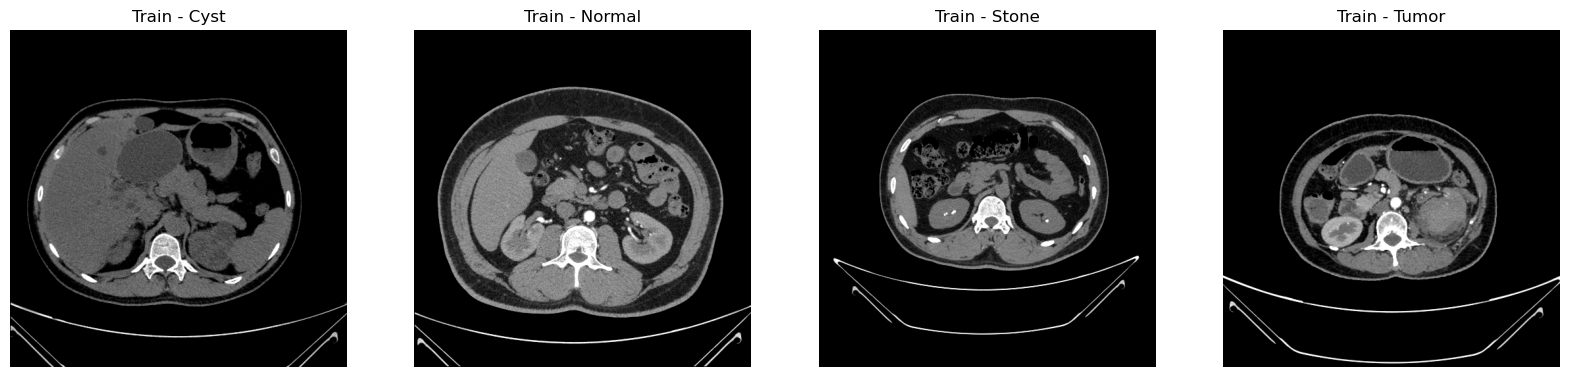

In [10]:
import os
import random  # Import the random module
from PIL import Image
import matplotlib.pyplot as plt

# Ensure that 'classes' and 'base_dir' are defined
classes = ['Cyst', 'Normal', 'Stone', 'Tumor']
base_dir = 'kidney_split_dataset'  # Replace with your actual base directory

def visualize_samples(directory, subset='train'):
    """
    Display sample images from each class in the specified subset.
    """
    fig, axes = plt.subplots(nrows=1, ncols=len(classes), figsize=(20, 5))

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, subset, class_name)
        img_list = os.listdir(class_dir)
        if not img_list:
            print(f"No images found in {class_dir}")
            axes[i].axis('off')
            axes[i].set_title(f'{subset.capitalize()} - {class_name} (No images)')
            continue
        img_name = random.choice(img_list)
        img_path = os.path.join(class_dir, img_name)
        try:
            img = Image.open(img_path)
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f'{subset.capitalize()} - {class_name}')
            axes[i].axis('off')
        except Exception as e:
            print(f"Error opening image {img_path}: {e}")
            axes[i].axis('off')
            axes[i].set_title(f'{subset.capitalize()} - {class_name} (Error)')

    plt.show()

# Visualize samples from the training set
visualize_samples(base_dir, 'train')


In [11]:
def preprocess_image(image):
    """
    Preprocess the input image:
    - Resize to IMG_HEIGHT x IMG_WIDTH
    - Convert to grayscale if needed
    - Normalize pixel values to [0, 1]
    """
    # Resize image
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    # Convert to grayscale if image has 3 channels
    if image.shape[-1] == 3:
        image = tf.image.rgb_to_grayscale(image)
    # Normalize image
    image = image / 255.0
    return image


In [12]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
])


In [13]:
# Prepare data generators with preprocessing function and data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True
)

# Validation data generator
validation_generator = validation_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'validation'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

# Test data generator
test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'test'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)


Found 9954 images belonging to 4 classes.
Found 1246 images belonging to 4 classes.
Found 1246 images belonging to 4 classes.


In [14]:
# Load the ResNet50 model pre-trained on ImageNet
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)  # ResNet50 expects 3-channel input
)


94765736/94765736 [==============================] - 54s 1us/step


In [15]:
# Freeze the base model
base_model.trainable = False

# Build the custom model
model = models.Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),  # Input layer for grayscale images
    layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)),     # Convert grayscale to RGB
    data_augmentation,                                         # Apply data augmentation
    base_model,                                                # Pre-trained base model
    layers.GlobalAveragePooling2D(),                           # Global average pooling
    layers.Dense(1024, activation='relu'),                     # Fully connected layer
    layers.Dropout(0.5),                                       # Dropout for regularization
    layers.Dense(len(classes), activation='softmax')           # Output layer for classification
])


In [16]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                      

In [17]:
# Define number of epochs
EPOCHS = 20

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS
)


Epoch 1/20
312/312 [==============================] - 156s 468ms/step - loss: 1.2999 - accuracy: 0.4446 - val_loss: 1.1171 - val_accuracy: 0.5554
Epoch 2/20
312/312 [==============================] - 91s 292ms/step - loss: 1.1196 - accuracy: 0.5523 - val_loss: 1.0509 - val_accuracy: 0.5883
Epoch 3/20
312/312 [==============================] - 84s 269ms/step - loss: 1.0567 - accuracy: 0.5746 - val_loss: 1.0022 - val_accuracy: 0.5979
Epoch 4/20
312/312 [==============================] - 91s 292ms/step - loss: 1.0184 - accuracy: 0.5942 - val_loss: 0.9847 - val_accuracy: 0.5891
Epoch 5/20
312/312 [==============================] - 83s 266ms/step - loss: 0.9773 - accuracy: 0.6070 - val_loss: 0.9466 - val_accuracy: 0.6268
Epoch 6/20
312/312 [==============================] - 91s 291ms/step - loss: 0.9432 - accuracy: 0.6208 - val_loss: 0.9304 - val_accuracy: 0.6348
Epoch 7/20
312/312 [==============================] - 82s 262ms/step - loss: 0.9234 - accuracy: 0.6297 - val_loss: 0.9049 - val_a

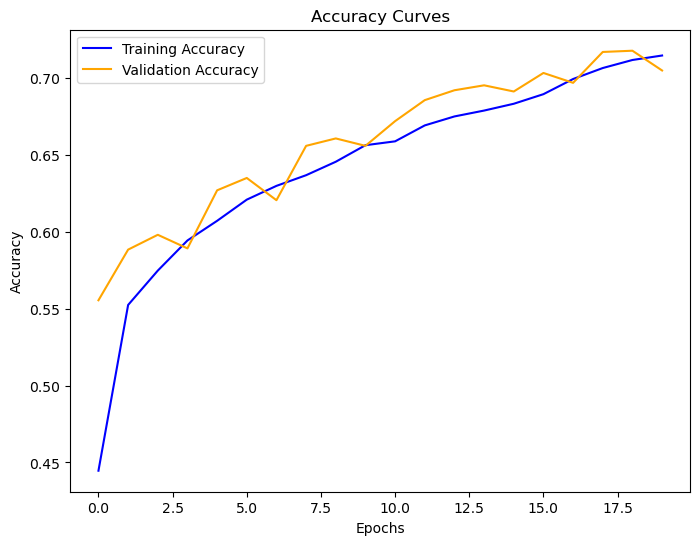

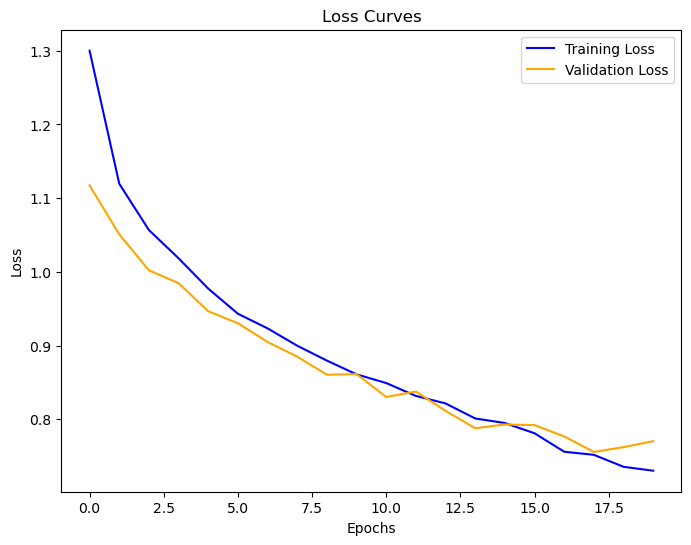

In [18]:
# Function to plot training history
def plot_training_history(history):
    """
    Plot the training and validation accuracy and loss curves.
    """
    # Accuracy curves
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Loss curves
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call the function to plot training history
plot_training_history(history)


39/39 [==============================] - 18s 419ms/step


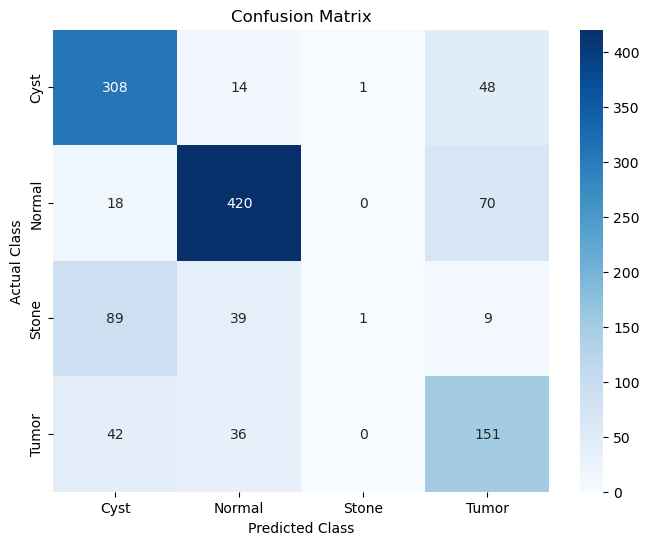

Classification Report:
              precision    recall  f1-score   support

        Cyst       0.67      0.83      0.74       371
      Normal       0.83      0.83      0.83       508
       Stone       0.50      0.01      0.01       138
       Tumor       0.54      0.66      0.60       229

    accuracy                           0.71      1246
   macro avg       0.64      0.58      0.54      1246
weighted avg       0.69      0.71      0.67      1246



In [19]:
# Evaluate the model on the test data
def evaluate_model(model, test_generator):
    """
    Evaluate the model using confusion matrix and classification report.
    """
    # Predict on test data
    test_steps = test_generator.samples // test_generator.batch_size + 1
    predictions = model.predict(test_generator, steps=test_steps)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

    # Classification report
    report = classification_report(y_true, y_pred, target_names=classes)
    print('Classification Report:')
    print(report)

# Call the function to evaluate the model
evaluate_model(model, test_generator)


In [22]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

# Define constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 20

# Define the base model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)
base_model.trainable = False  # Freeze the base model

# Build the model using the Functional API
inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))  # Grayscale images
x = layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x))(inputs)  # Convert to RGB
x = data_augmentation(x)  # Apply data augmentation
x = base_model(x, training=False)  # Pass through the base model
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(classes), activation='softmax')(x)  # Adjust for your number of classes

model = models.Model(inputs, outputs)
